# Seminar 1. Word Embeddings and LMs

## Part 1. Fun with Word Embeddings

Today we gonna play with word embeddings: train our own little embedding, load one from   gensim model zoo and use it to visualize text corpora.

This whole thing is gonna happen on top of embedding dataset.

__Requirements:__  `pip install --upgrade nltk gensim bokeh` , but only if you're running locally.

In [ ]:
# download the data:
!wget https://www.dropbox.com/s/obaitrix9jyu84r/quora.txt?dl=1 -O ./quora.txt
# alternative download link: https://yadi.sk/i/BPQrUu1NaTduEw

In [ ]:
import numpy as np

data = list(open("./quora.txt", encoding="utf-8"))
data[50]

__Tokenization:__ a typical first step for an nlp task is to split raw data into words.
The text we're working with is in raw format: with all the punctuation and smiles attached to some words, so a simple str.split won't do.

Let's use __`nltk`__ - a library that handles many nlp tasks like tokenization, stemming or part-of-speech tagging.

In [ ]:
from nltk.tokenize import WordPunctTokenizer
tokenizer = WordPunctTokenizer()

print(tokenizer.tokenize(data[50]))

In [ ]:
# TASK: lowercase everything and extract tokens with tokenizer. 
# data_tok should be a list of lists of tokens for each line in data.

data_tok = # YOUR CODE

In [ ]:
assert all(isinstance(row, (list, tuple)) for row in data_tok), "please convert each line into a list of tokens (strings)"
assert all(all(isinstance(tok, str) for tok in row) for row in data_tok), "please convert each line into a list of tokens (strings)"
is_latin = lambda tok: all('a' <= x.lower() <= 'z' for x in tok)
assert all(map(lambda l: not is_latin(l) or l.islower(), map(' '.join, data_tok))), "please make sure to lowercase the data"

In [ ]:
print([' '.join(row) for row in data_tok[:2]])

__Word vectors:__ as the saying goes, there's more than one way to train word embeddings. There's Word2Vec and GloVe with different objective functions. Then there's fasttext that uses character-level models to train word embeddings. 

The choice is huge, so let's start someplace small: __gensim__ is another nlp library that features many vector-based models incuding word2vec.

In [ ]:
from gensim.models import Word2Vec
model = Word2Vec(data_tok, 
                 vector_size=32,      # embedding vector size
                 min_count=5,  # consider words that occured at least 5 times
                 window=5).wv  # define context as a 5-word window around the target word

In [ ]:
# now you can get word vectors !
model.get_vector('anything')

In [ ]:
# or query similar words directly. Go play with it!
model.most_similar('bread')

### Using pre-trained model

Took it a while, huh? Now imagine training life-sized (100~300D) word embeddings on gigabytes of text: wikipedia articles or twitter posts. 

Thankfully, nowadays you can get a pre-trained word embedding model in 2 lines of code (no sms required, promise).

In [ ]:
import gensim.downloader as api
model = api.load('glove-twitter-100')

In [ ]:
model.most_similar(positive=["coder", "money"], negative=["brain"])

### Visualizing word vectors

One way to see if our vectors are any good is to plot them. Thing is, those vectors are in 30D+ space and we humans are more used to 2-3D.

Luckily, we machine learners know about __dimensionality reduction__ methods.

Let's use that to plot 1000 most frequent words

In [ ]:
words = model.index_to_key[:1000] 

print(words[::100])

In [ ]:
# for each word, compute it's vector with model
word_vectors = # YOUR CODE

In [ ]:
assert isinstance(word_vectors, np.ndarray)
assert word_vectors.shape == (len(words), 100)
assert np.isfinite(word_vectors).all()

#### Linear projection: PCA

The simplest linear dimensionality reduction method is __P__rincipial __C__omponent __A__nalysis.

In geometric terms, PCA tries to find axes along which most of the variance occurs. The "natural" axes, if you wish.

<img src="https://github.com/yandexdataschool/Practical_RL/raw/master/yet_another_week/_resource/pca_fish.png" style="width:30%">


Under the hood, it attempts to decompose object-feature matrix $X$ into two smaller matrices: $W$ and $\hat W$ minimizing _mean squared error_:

$$\|(X W) \hat{W} - X\|^2_2 \to_{W, \hat{W}} \min$$
- $X \in \mathbb{R}^{n \times m}$ - object matrix (**centered**);
- $W \in \mathbb{R}^{m \times d}$ - matrix of direct transformation;
- $\hat{W} \in \mathbb{R}^{d \times m}$ - matrix of reverse transformation;
- $n$ samples, $m$ original dimensions and $d$ target dimensions;



In [ ]:
from sklearn.decomposition import PCA

# map word vectors onto 2d plane with PCA. Use good old sklearn api (fit, transform)
# after that, normalize vectors to make sure they have zero mean and unit variance
word_vectors_pca = # YOUR CODE

# and maybe MORE OF YOUR CODE here :)

In [ ]:
assert word_vectors_pca.shape == (len(word_vectors), 2), "there must be a 2d vector for each word"
assert max(abs(word_vectors_pca.mean(0))) < 1e-5, "points must be zero-centered"
assert max(abs(1.0 - word_vectors_pca.std(0))) < 1e-2, "points must have unit variance"

#### Let's draw it!

In [ ]:
import bokeh.models as bm, bokeh.plotting as pl
from bokeh.io import output_notebook
output_notebook()

def draw_vectors(x, y, radius=10, alpha=0.25, color='blue',
                 width=600, height=400, show=True, **kwargs):
    """ draws an interactive plot for data points with auxilirary info on hover """
    if isinstance(color, str): color = [color] * len(x)
    data_source = bm.ColumnDataSource({ 'x' : x, 'y' : y, 'color': color, **kwargs })

    fig = pl.figure(active_scroll='wheel_zoom', width=width, height=height)
    fig.scatter('x', 'y', size=radius, color='color', alpha=alpha, source=data_source)

    fig.add_tools(bm.HoverTool(tooltips=[(key, "@" + key) for key in kwargs.keys()]))
    if show: pl.show(fig)
    return fig

In [ ]:
draw_vectors(word_vectors_pca[:, 0], word_vectors_pca[:, 1], token=words)

# hover a mouse over there and see if you can identify the clusters

### Visualizing neighbors with t-SNE
PCA is nice but it's strictly linear and thus only able to capture coarse high-level structure of the data.

If we instead want to focus on keeping neighboring points near, we could use TSNE, which is itself an embedding method. Here you can read __[more on TSNE](https://distill.pub/2016/misread-tsne/)__.

In [ ]:
from sklearn.manifold import TSNE

# map word vectors onto 2d plane with TSNE. hint: don't panic it may take a minute or two to fit.
# normalize them as just lke with pca


word_tsne = #YOUR CODE

In [ ]:
draw_vectors(word_tsne[:, 0], word_tsne[:, 1], color='green', token=words)

### Summary

* Use `nltk.tokenize` for simple tokenization
* Use `gensim` for vector-based models (such as Word2Vec)
* `PCA`, `tSNE` for dimensionality reduction

## Part 2. Main Modules in PyTorch

1.  **`torch`**

    This is the base library. It contains the `Tensor` object and a huge number of mathematical functions that operate on Tensors (like `torch.add`, `torch.matmul`, `torch.sigmoid`, etc.). It's the equivalent of the base `numpy` library.

2.  **`torch.nn`** (Neural Networks)

    This is where the "Lego Kits" are. It provides all the building blocks for creating neural networks.

    > **Layers:** Pre-built layers like `nn.Linear` (a standard fully-connected layer), `nn.Conv2d` (for images), and `nn.LSTM` (for sequences).
    >
    > **Loss Functions:** Ways to measure your model's error, like `nn.MSELoss` (Mean Squared Error for regression) or `nn.CrossEntropyLoss` (for classification).
    >
    > **Containers:** A special class called `nn.Module`. All of your models will be classes that inherit from `nn.Module`. This gives them the ability to track parameters, move to the GPU, and more.

3.  **`torch.autograd`**

    You rarely use this directly, but it's the engine running under the hood. When you create a tensor with `requires_grad=True`, `autograd` starts building a graph of operations. When you call `.backward()` on a result (like your loss), it travels backward through this graph, calculating the gradients for each parameter.

4.  **`torch.optim`** (Optimizers)

    This module contains algorithms to update your model's weights based on the gradients calculated by `autograd`. This is the "how to improve" part. You give it your model's parameters and a learning rate, and it handles the updates.

    **Common optimizers include:** `optim.SGD` (Stochastic Gradient Descent), `optim.Adam`, and `optim.RMSprop`.

5.  **`torch.utils.data`**

    Deep learning requires a lot of data. This module provides tools to make data loading easy and efficient.

    > **`Dataset`:** A class you can use to represent your dataset. You typically implement `__len__` (to return the size) and `__getitem__` (to get a single data point).
    >
    > **`DataLoader`:** This is a magical utility. You wrap your `Dataset` in a `DataLoader`, and it will automatically handle batching your data, shuffling it, and even loading it in parallel using multiple CPU cores. This prevents your GPU from sitting idle waiting for data.

### Tensors

**Tensors** are PyTorch's most basic building block. Each tensor is a multi-dimensional matrix; for example, a 256x256 square image might be represented by a `3x256x256` tensor, where the first dimension represents color. Here's how to create a tensor:


In [89]:
list_of_lists = [
  [1, 2, 3],
  [4, 5, 6],
]
print(list_of_lists)

[[1, 2, 3], [4, 5, 6]]


In [90]:
data = torch.tensor(list_of_lists)
print(data)

tensor([[1, 2, 3],
        [4, 5, 6]])


In [91]:
# Initializing a tensor
data = torch.tensor([
                     [0, 1],
                     [2, 3],
                     [4, 5]
                    ])
print(data)

tensor([[0, 1],
        [2, 3],
        [4, 5]])


Each tensor has a **data type**: the major data types you'll need to worry about are floats (`torch.float32`) and integers (`torch.int`). You can specify the data type explicitly when you create the tensor:

In [92]:
# Initializing a tensor with an explicit data type
# Notice the dots after the numbers, which specify that they're floats
data = torch.tensor([
                     [0, 1],
                     [2, 3],
                     [4, 5]
                    ], dtype=torch.float32)
print(data)

tensor([[0., 1.],
        [2., 3.],
        [4., 5.]])


In [93]:
# Initializing a tensor with an explicit data type
# Notice the dots after the numbers, which specify that they're floats
data = torch.tensor([
                     [0.11111111, 1],
                     [2, 3],
                     [4, 5]
                    ], dtype=torch.float32)
print(data)

tensor([[0.1111, 1.0000],
        [2.0000, 3.0000],
        [4.0000, 5.0000]])


In [94]:
# Initializing a tensor with an explicit data type
# Notice the dots after the numbers, which specify that they're floats
data = torch.tensor([
                     [0.11111111, 1],
                     [2, 3],
                     [4, 5]
                    ])
print(data)

tensor([[0.1111, 1.0000],
        [2.0000, 3.0000],
        [4.0000, 5.0000]])


!!! Don't confuse torch.tensor with torch.Tensor.

torch.tensor returns tensor with type of input data.

torch.Tensor returns tensor with type FloatTensor.





Utility functions also exist to create tensors with given shapes and contents:

In [95]:
zeros = torch.zeros(2, 5)  # a tensor of all zeros
print(zeros)

tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])


In [96]:
ones = torch.ones(3, 4)   # a tensor of all ones
print(ones)

tensor([[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.]])


In [97]:
rr = torch.arange(1, 10) # range from [1, 10)
print(rr)

tensor([1, 2, 3, 4, 5, 6, 7, 8, 9])


In [98]:
rr + 2

tensor([ 3,  4,  5,  6,  7,  8,  9, 10, 11])

In [99]:
rr * 2

tensor([ 2,  4,  6,  8, 10, 12, 14, 16, 18])

In [100]:
a = torch.tensor([[1, 2], [2, 3], [4, 5]])      # (3, 2)
b = torch.tensor([[1, 2, 3, 4], [5, 6, 7, 8]])  # (2, 4)

print("A is", a)
print("B is", b)
print("The product is", a.matmul(b)) #(3, 4)
print("The other product is", a @ b) # +, -, *, @

A is tensor([[1, 2],
        [2, 3],
        [4, 5]])
B is tensor([[1, 2, 3, 4],
        [5, 6, 7, 8]])
The product is tensor([[11, 14, 17, 20],
        [17, 22, 27, 32],
        [29, 38, 47, 56]])
The other product is tensor([[11, 14, 17, 20],
        [17, 22, 27, 32],
        [29, 38, 47, 56]])


The **shape** of a matrix (which can be accessed by `.shape`) is defined as the dimensions of the matrix. Here's some examples:

In [101]:
matr_2d = torch.tensor([[1, 2, 3], [4, 5, 6]])
print(matr_2d.shape)
print(matr_2d)

torch.Size([2, 3])
tensor([[1, 2, 3],
        [4, 5, 6]])


In [102]:
matr_3d = torch.tensor([[[1, 2, 3, 4], [-2, 5, 6, 9]], [[5, 6, 7, 2], [8, 9, 10, 4]], [[-3, 2, 2, 1], [4, 6, 5, 9]]])
print(matr_3d)
print(matr_3d.shape)

tensor([[[ 1,  2,  3,  4],
         [-2,  5,  6,  9]],

        [[ 5,  6,  7,  2],
         [ 8,  9, 10,  4]],

        [[-3,  2,  2,  1],
         [ 4,  6,  5,  9]]])
torch.Size([3, 2, 4])


**Reshaping** tensors can be used to make batch operations easier (more on that later), but be careful that the data is reshaped in the order you expect:

In [103]:
rr = torch.arange(1, 16)
print("The shape is currently", rr.shape)
print("The contents are currently", rr)
print()
rr = rr.view(5, 3)
print("After reshaping, the shape is currently", rr.shape)
print("The contents are currently", rr)

The shape is currently torch.Size([15])
The contents are currently tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])

After reshaping, the shape is currently torch.Size([5, 3])
The contents are currently tensor([[ 1,  2,  3],
        [ 4,  5,  6],
        [ 7,  8,  9],
        [10, 11, 12],
        [13, 14, 15]])


!!! Be careful with rr.reshape, it is better to use rr.view.

Finally, you can also inter-convert tensors with **NumPy arrays**:

In [104]:
import numpy as np

# numpy.ndarray --> torch.Tensor:
arr = np.array([[1, 0, 5]])
data = torch.tensor(arr)
print("This is a torch.tensor", data)

# torch.Tensor --> numpy.ndarray:
new_arr = data.numpy()
print("This is a np.ndarray", new_arr)

This is a torch.tensor tensor([[1, 0, 5]])
This is a np.ndarray [[1 0 5]]


One of the reasons why we use **tensors** is *vectorized operations*: operations that be conducted in parallel over a particular dimension of a tensor.

In [105]:
data = torch.arange(1, 36, dtype=torch.float32).reshape(5, 7)
print("Data is:", data)

# We can perform operations like *sum* over each row...
print("Taking the sum over rows:")
print(data.sum(dim=1)) #(5,)

# or over each column.
print("Taking thep sum over columns:")
print(data.sum(dim=0)) #(7,)

# Other operations are available:
print("Taking the stdev over rows:")
print(data.std(dim=1))


Data is: tensor([[ 1.,  2.,  3.,  4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11., 12., 13., 14.],
        [15., 16., 17., 18., 19., 20., 21.],
        [22., 23., 24., 25., 26., 27., 28.],
        [29., 30., 31., 32., 33., 34., 35.]])
Taking the sum over rows:
tensor([ 28.,  77., 126., 175., 224.])
Taking thep sum over columns:
tensor([ 75.,  80.,  85.,  90.,  95., 100., 105.])
Taking the stdev over rows:
tensor([2.1602, 2.1602, 2.1602, 2.1602, 2.1602])


In [106]:
data = torch.arange(1, 7, dtype=torch.float32).reshape(1, 2, 3)
print(data)
print(data.sum(dim=0).sum(dim=0))
print(data.sum(dim=0).sum(dim=0).shape)

tensor([[[1., 2., 3.],
         [4., 5., 6.]]])
tensor([5., 7., 9.])
torch.Size([3])


In [107]:
data.sum()

tensor(21.)

**Indexing**

You can access arbitrary elements of a tensor using the `[]` operator.

In [108]:
# Initialize an example tensor
x = torch.Tensor([
                  [[1, 2], [3, 4]],
                  [[5, 6], [7, 8]],
                  [[9, 10], [11, 12]]
                 ])
x

tensor([[[ 1.,  2.],
         [ 3.,  4.]],

        [[ 5.,  6.],
         [ 7.,  8.]],

        [[ 9., 10.],
         [11., 12.]]])

In [109]:
x.shape

torch.Size([3, 2, 2])

In [110]:
# Access the 0th element, which is the first row
x[0] # Equivalent to x[0, :]

tensor([[1., 2.],
        [3., 4.]])

In [111]:
x[:, 0]

tensor([[ 1.,  2.],
        [ 5.,  6.],
        [ 9., 10.]])

We can also index into multiple dimensions with `:`.

In [112]:
# Get the top left element of each element in our tensor
x[:, 0, 0]

tensor([1., 5., 9.])

In [113]:
x[:, :, :]

tensor([[[ 1.,  2.],
         [ 3.,  4.]],

        [[ 5.,  6.],
         [ 7.,  8.]],

        [[ 9., 10.],
         [11., 12.]]])

We can also access arbitrary elements in each dimension.

In [114]:
# Let's access the 0th and 1st elements, each twice
# same as stacking x[0], x[0], x[1], x[1]
i = torch.tensor([0, 0, 1, 1])
x[i]

tensor([[[1., 2.],
         [3., 4.]],

        [[1., 2.],
         [3., 4.]],

        [[5., 6.],
         [7., 8.]],

        [[5., 6.],
         [7., 8.]]])

In [115]:
# Let's access the 0th elements of the 1st and 2nd elements

i = torch.tensor([1, 2])
j = torch.tensor([0])
x[i, j]

tensor([[ 5.,  6.],
        [ 9., 10.]])

We can get a `Python` scalar value from a tensor with `item()`.

In [116]:
x[0, 0, 0]

tensor(1.)

In [117]:
x[0, 0, 0].item()

1.0

#### Exercise:

Write code that creates a `torch.tensor` with the following contents:
$\begin{bmatrix} 1 & 2.2 & 9.6 \\ 4 & -7.2 & 6.3 \end{bmatrix}$

How do you get the first column? The first row?



In [118]:
# Your code


### Summary

* `x_tensor = torch.tensor(x_list)`; `x_tensor = torch.tensor(x_np_array)` or `x_tensor = torch.from_numpy(x_np_array)`
* `torch.zeros`, `torch.ones`, `torch.arange`, `torch.randn` and more to create tensors filled with values
* `x_tensor.shape` for shape
* `x_tensor[0, :, -1]` indexing is mostly numpy-like
* `x_tensor.reshape` or `x_tensor.view` for reshaping

### Autograd
Pytorch is well-known for its automatic differentiation feature. We can call the `backward()` method to ask `PyTorch` to calculate the gradients, which are then stored in the `grad` attribute.

In [119]:
# Create an example tensor
# requires_grad parameter tells PyTorch to store gradients
x = torch.tensor([2.], requires_grad=True)

# Print the gradient if it is calculated
# Currently None since x is a scalar
pp.pprint(x.grad)

None


In [120]:
# Calculating the gradient of y with respect to x
y = x * x * 3 # 3x^2
y.backward()
pp.pprint(x.grad)

tensor([12.])


Let's run backprop from a different tensor again to see what happens.

In [121]:
z = x * x * 3 # 3x^2
z.backward()
pp.pprint(x.grad)

tensor([24.])


What just happened?

In [122]:
x.grad = None
z = x * x * 3 # 3x^2
z.backward()
# y = x * x * 3
pp.pprint(x.grad)

tensor([12.])


In [123]:
z = x * x * 3 # 3x^2
z.backward()
# y = x * x * 3
pp.pprint(x.grad)

tensor([24.])


In [124]:
z = x * x * 3 # 3x^2
z.backward()
# y = x * x * 3
pp.pprint(x.grad)

tensor([36.])


We can see that the `x.grad` is updated to be the sum of the gradients calculated so far. When we run backprop in a neural network, we sum up all the gradients for a particular neuron before making an update. This is exactly what is happening here! This is also the reason why we need to run `zero_grad()` in every training iteration (more on this later). Otherwise our gradients would keep building up from one training iteration to the other, which would cause our updates to be wrong.

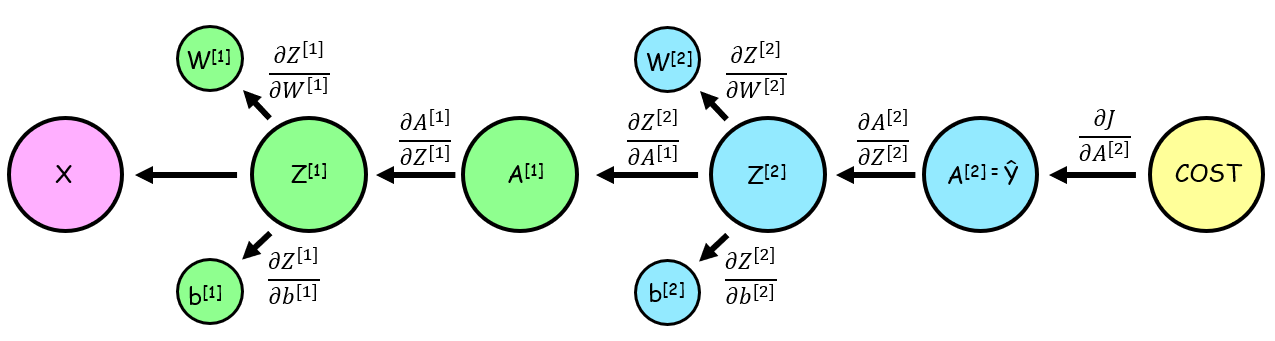

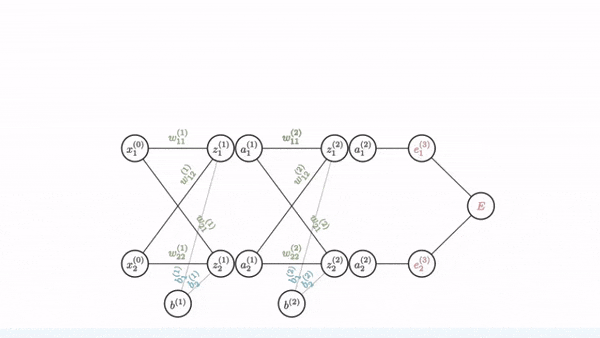

Please, watch a [video](https://vk.com/video-155161349_456239205) in RUSSIAN about backpropagation if you don't understand it.

### Neural Network Module

So far we have looked into the tensors, their properties and basic operations on tensors. These are especially useful to get familiar with if we are building the layers of our network from scratch. We will use predefined blocks in the `torch.nn` module of `PyTorch`. We will then put together these blocks to create complex networks. Let's start by importing this module with an alias so that we don't have to type `torch` every time we use it.

In [125]:
import torch.nn as nn
import torch

#### **Linear Layer**
We can use `nn.Linear(H_in, H_out)` to create a a linear layer. This will take a matrix of `(N, *, H_in)` dimensions and output a matrix of `(N, *, H_out)`. The `*` denotes that there could be arbitrary number of dimensions in between. The linear layer performs the operation `Ax+b`, where `A` and `b` are initialized randomly. If we don't want the linear layer to learn the bias parameters, we can initialize our layer with `bias=False`.

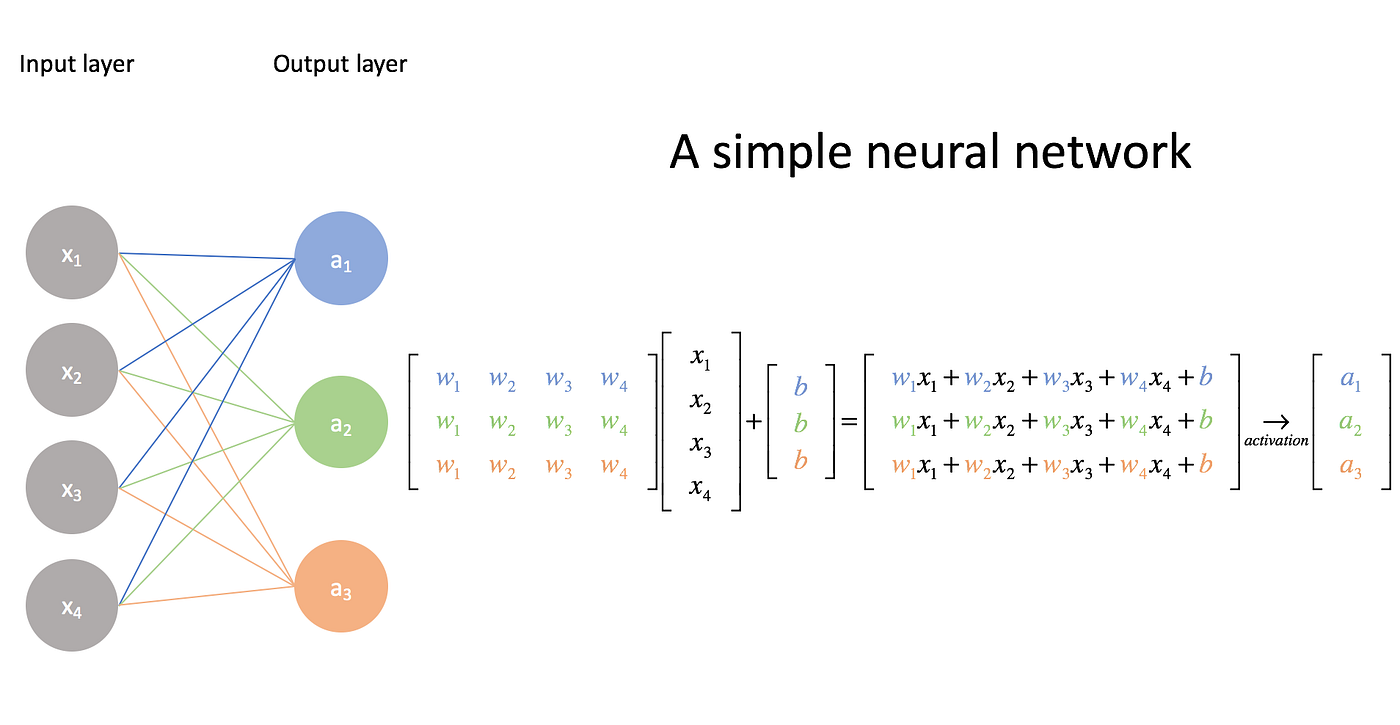

In [126]:
# Create the inputs
input = torch.ones(2,3,4)
# N* H_in -> N*H_out


# Make a linear layers transforming N,*,H_in dimensinal inputs to N,*,H_out
# dimensional outputs
# Your code
linear = nn.Linear(4, 2)
linear_output = linear(input)
linear_output

tensor([[[-0.2622,  0.2545],
         [-0.2622,  0.2545],
         [-0.2622,  0.2545]],

        [[-0.2622,  0.2545],
         [-0.2622,  0.2545],
         [-0.2622,  0.2545]]], grad_fn=<ViewBackward0>)

In [127]:
linear_output.shape

torch.Size([2, 3, 2])

In [128]:
list(linear.parameters()) # Ax + b

[Parameter containing:
 tensor([[-0.0714,  0.1831,  0.1683, -0.4080],
         [ 0.3401,  0.1907, -0.2754,  0.0613]], requires_grad=True),
 Parameter containing:
 tensor([-0.1342, -0.0622], requires_grad=True)]

In [129]:
# Data of shape [batch_size, feature_dim] # 4
# [batch_size, output_dim] # 2

# linear layer of shape (feature_dim, output_dim)

#### **Other Module Layers**
There are several other preconfigured layers in the `nn` module. Some commonly used examples are `nn.Conv2d`, `nn.ConvTranspose2d`, `nn.BatchNorm1d`, `nn.BatchNorm2d`, `nn.Upsample` and `nn.MaxPool2d` among many others. We will learn more about these as we progress in the course. For now, the only important thing to remember is that we can treat each of these layers as plug and play components: we will be providing the required dimensions and `PyTorch` will take care of setting them up.

#### **Activation Function Layer**
We can also use the `nn` module to apply activations functions to our tensors. Activation functions are used to add non-linearity to our network. Some examples of activations functions are `nn.ReLU()`, `nn.Sigmoid()` and `nn.LeakyReLU()`. Activation functions operate on each element seperately, so the shape of the tensors we get as an output are the same as the ones we pass in.

In [130]:
linear_output

tensor([[[-0.2622,  0.2545],
         [-0.2622,  0.2545],
         [-0.2622,  0.2545]],

        [[-0.2622,  0.2545],
         [-0.2622,  0.2545],
         [-0.2622,  0.2545]]], grad_fn=<ViewBackward0>)

In [131]:
sigmoid = nn.Sigmoid()
output = sigmoid(linear_output)
output

tensor([[[0.4348, 0.5633],
         [0.4348, 0.5633],
         [0.4348, 0.5633]],

        [[0.4348, 0.5633],
         [0.4348, 0.5633],
         [0.4348, 0.5633]]], grad_fn=<SigmoidBackward0>)

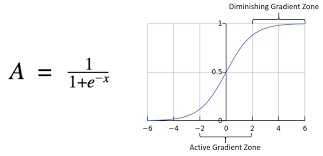

### **Putting the Layers Together**
So far we have seen that we can create layers and pass the output of one as the input of the next. Instead of creating intermediate tensors and passing them around, we can use `nn.Sequentual`, which does exactly that.

In [132]:
block = nn.Sequential(
    nn.Linear(4, 2),
    nn.Sigmoid()
)

input = torch.ones(2,3,4)
output = block(input)
output

tensor([[[0.4123, 0.5486],
         [0.4123, 0.5486],
         [0.4123, 0.5486]],

        [[0.4123, 0.5486],
         [0.4123, 0.5486],
         [0.4123, 0.5486]]], grad_fn=<SigmoidBackward0>)

### Custom Modules

Instead of using the predefined modules, we can also build our own by extending the `nn.Module` class. For example, we can build a the `nn.Linear` (which also extends `nn.Module`) on our own using the tensor introduced earlier! We can also build new, more complex modules, such as a custom neural network. You will be practicing these in the later assignment.

To create a custom module, the first thing we have to do is to extend the `nn.Module`. We can then initialize our parameters in the `__init__` function, starting with a call to the `__init__` function of the super class. All the class attributes we define which are `nn` module objects are treated as parameters, which can be learned during the training. Tensors are not parameters, but they can be turned into parameters if they are wrapped in `nn.Parameter` class.

All classes extending `nn.Module` are also expected to implement a `forward(x)` function, where `x` is a tensor. This is the function that is called when a parameter is passed to our module, such as in `model(x)`.

In [133]:
class MultilayerPerceptron(nn.Module):

  def __init__(self, input_size, hidden_size):
    # Call to the __init__ function of the super class
    super().__init__()

    # Bookkeeping: Saving the initialization parameters
    self.input_size = input_size
    self.hidden_size = hidden_size

    # Defining of our model
    # There isn't anything specific about the naming of `self.model`. It could
    # be something arbitrary.
    self.model = nn.Sequential(
        nn.Linear(self.input_size, self.hidden_size),
        nn.ReLU(),
        nn.Linear(self.hidden_size, self.input_size),
        nn.Sigmoid()
    )

  def forward(self, x):
    output = self.model(x)
    return output

Here is an alternative way to define the same class. You can see that we can replace `nn.Sequential` by defining the individual layers in the `__init__` method and connecting the in the `forward` method.

In [134]:
class MultilayerPerceptron(nn.Module):

  def __init__(self, input_size, hidden_size):
    # Call to the __init__ function of the super class
    super().__init__()

    # Bookkeeping: Saving the initialization parameters
    self.input_size = input_size
    self.hidden_size = hidden_size

    # Defining of our layers
    self.linear = nn.Linear(self.input_size, self.hidden_size)
    self.relu = nn.ReLU()
    self.linear2 = nn.Linear(self.hidden_size, self.input_size)
    self.sigmoid = nn.Sigmoid()

  def forward(self, x):
    linear = self.linear(x)
    relu = self.relu(linear)
    linear2 = self.linear2(relu)
    output = self.sigmoid(linear2)
    return output

Now that we have defined our class, we can instantiate it and see what it does.

In [135]:
# Make a sample input
input = torch.randn(2, 5)

# Create our model
model = MultilayerPerceptron(5, 3)

# Pass our input through our model
model(input)

tensor([[0.6085, 0.4179, 0.4451, 0.5120, 0.3183],
        [0.5690, 0.4108, 0.4707, 0.4472, 0.3213]], grad_fn=<SigmoidBackward0>)

We can inspect the parameters of our model with `named_parameters()` and `parameters()` methods.

In [136]:
list(model.named_parameters())

[('linear.weight',
  Parameter containing:
  tensor([[ 0.3389, -0.3912,  0.2910,  0.0710, -0.3517],
          [-0.0409,  0.3221,  0.3916, -0.1141, -0.2853],
          [-0.2538,  0.3420, -0.1027,  0.3690,  0.0661]], requires_grad=True)),
 ('linear.bias',
  Parameter containing:
  tensor([ 0.2253, -0.1155, -0.2242], requires_grad=True)),
 ('linear2.weight',
  Parameter containing:
  tensor([[ 0.3321,  0.2718, -0.3528],
          [ 0.0791, -0.1085, -0.4380],
          [-0.4464, -0.2594, -0.0722],
          [ 0.3156,  0.5287, -0.3990],
          [-0.4244, -0.1052, -0.3077]], requires_grad=True)),
 ('linear2.bias',
  Parameter containing:
  tensor([ 0.1033, -0.3021,  0.1666, -0.4444, -0.4833], requires_grad=True))]

### Optimization
We have showed how gradients are calculated with the `backward()` function. Having the gradients isn't enought for our models to learn. We also need to know how to update the parameters of our models. This is where the optomozers comes in. `torch.optim` module contains several optimizers that we can use. Some popular examples are `optim.SGD` and `optim.Adam`. When initializing optimizers, we pass our model parameters, which can be accessed with `model.parameters()`, telling the optimizers which values it will be optimizing. Optimizers also has a learning rate (`lr`) parameter, which determines how big of an update will be made in every step. Different optimizers have different hyperparameters as well.

In [137]:
import torch.optim as optim

After we have our optimization function, we can define a `loss` that we want to optimize for. We can either define the loss ourselves, or use one of the predefined loss function in `PyTorch`, such as `nn.BCELoss()`. Let's put everything together now! We will start by creating some dummy data.

In [138]:
# Create the y data
y = torch.ones(10, 5)

# Add some noise to our goal y to generate our x
# We want out model to predict our original data, albeit the noise
x = y + torch.randn_like(y)
x

tensor([[ 1.3765, -0.6371,  0.4273,  1.7571,  0.5002],
        [ 2.3304,  2.1821,  0.9149,  0.3020,  1.4407],
        [ 0.9951,  1.1213,  0.3425, -0.0546,  0.4395],
        [ 2.4713,  1.3027,  1.1747,  1.1209,  2.8363],
        [ 2.3774,  2.0263,  2.5719,  1.3411, -0.2954],
        [ 2.3347, -0.1992,  1.4411,  2.8139,  1.5296],
        [ 0.4137,  2.2070,  1.4053,  1.4150,  1.5568],
        [ 1.8883, -0.4805,  0.5026, -0.7640, -0.2618],
        [-0.7256,  0.3107, -1.0429,  0.7204,  1.3239],
        [ 0.2710,  0.0540,  1.1841,  1.4047,  0.9001]])

Now, we can define our model, optimizer and the loss function.

In [139]:
# Instantiate the model
model = MultilayerPerceptron(5, 3)

# Define the optimizer
adam = optim.Adam(model.parameters(), lr=1e-1)

# Define loss using a predefined loss function
loss_function = nn.MSELoss()

# Calculate how our model is doing now
y_pred = model(x)
loss_function(y_pred, y).item()

0.25423458218574524

Let's see if we can have our model achieve a smaller loss. Now that we have everything we need, we can setup our training loop.

In [140]:
# Set the number of epoch, which determines the number of training iterations
n_epoch = 10

for epoch in range(n_epoch):
  # Set the gradients to 0
  adam.zero_grad()

  # Get the model predictions
  y_pred = model(x)

  # Get the loss
  loss = loss_function(y_pred, y)

  # Print stats
  print(f"Epoch {epoch}: traing loss: {loss}")

  # Compute the gradients
  loss.backward()

  # Take a step to optimize the weights
  adam.step()


Epoch 0: traing loss: 0.25423458218574524
Epoch 1: traing loss: 0.16594503819942474
Epoch 2: traing loss: 0.10688162595033646
Epoch 3: traing loss: 0.06441553682088852
Epoch 4: traing loss: 0.037539880722761154
Epoch 5: traing loss: 0.022610673680901527
Epoch 6: traing loss: 0.013234150595963001
Epoch 7: traing loss: 0.007887506857514381
Epoch 8: traing loss: 0.004699023440480232
Epoch 9: traing loss: 0.002766030142083764


In [141]:
list(model.parameters())

[Parameter containing:
 tensor([[-0.7748, -0.5615, -0.7180, -0.1349, -0.1135],
         [ 0.6640,  1.0794,  0.5088,  0.7678,  1.1414],
         [-0.0971, -0.3012, -0.2938, -0.6451, -0.2888]], requires_grad=True),
 Parameter containing:
 tensor([-0.1102,  0.9180, -0.6533], requires_grad=True),
 Parameter containing:
 tensor([[ 0.0715,  0.8658,  0.0584],
         [ 0.3302,  1.3070,  0.6598],
         [ 0.7756,  0.6355,  0.8676],
         [ 0.1177,  1.1509, -0.0585],
         [ 0.0644,  1.2784,  0.4249]], requires_grad=True),
 Parameter containing:
 tensor([1.1453, 1.2909, 1.2211, 0.5447, 0.7458], requires_grad=True)]

You can see that our loss is decreasing. Let's check the predictions of our model now and see if they are close to our original `y`, which was all `1s`.

In [142]:
# See how our model performs on the training data
y_pred = model(x)
y_pred

tensor([[0.9818, 0.9962, 0.9647, 0.9869, 0.9929],
        [0.9994, 1.0000, 0.9969, 0.9998, 0.9999],
        [0.9838, 0.9969, 0.9676, 0.9888, 0.9941],
        [0.9998, 1.0000, 0.9988, 1.0000, 1.0000],
        [0.9990, 1.0000, 0.9958, 0.9997, 0.9999],
        [0.9992, 1.0000, 0.9963, 0.9998, 0.9999],
        [0.9994, 1.0000, 0.9969, 0.9998, 0.9999],
        [0.8841, 0.9327, 0.8666, 0.8485, 0.8864],
        [0.9607, 0.9897, 0.9641, 0.9641, 0.9769],
        [0.9889, 0.9982, 0.9753, 0.9933, 0.9966]], grad_fn=<SigmoidBackward0>)

In [143]:
# Create test data and check how our model performs on it
x2 = y + torch.randn_like(y)
y_pred = model(x2)
y_pred

tensor([[0.9817, 0.9962, 0.9645, 0.9868, 0.9928],
        [0.9907, 0.9987, 0.9783, 0.9947, 0.9974],
        [0.9970, 0.9998, 0.9906, 0.9988, 0.9995],
        [0.9975, 0.9998, 0.9916, 0.9991, 0.9996],
        [0.9902, 0.9985, 0.9775, 0.9943, 0.9972],
        [0.9980, 0.9999, 0.9928, 0.9993, 0.9997],
        [0.9750, 0.9939, 0.9556, 0.9800, 0.9886],
        [0.9996, 1.0000, 0.9977, 0.9999, 1.0000],
        [0.9986, 0.9999, 0.9945, 0.9996, 0.9998],
        [0.9990, 1.0000, 0.9956, 0.9997, 0.9999]], grad_fn=<SigmoidBackward0>)

Great! Looks like our model almost perfectly learned to filter out the noise from the `x` that we passed in!

### Summary

* STACK MORE LAYERS: `nn.Linear`, `nn.Conv1d`, `nn.BatchNorm2d` etc.
* Loss functions (`nn.MSELoss` for example)
* Optimization `optimizer = optim.Adam(model.parameters(), lr=<YOUR LEARNING RATE>)`
* Forward pass (train):

`y_train_pred = model(x_train)`

* Loss: `loss = loss_func(y_gt, y_train_pred)`

* Backward step:

```
optimizer.zero_grad()
loss.backward()
optimizer.step()
```

* Forward pass (inference trained model):

```
with torch.no_grad():
    y_test_pred = model(x_test)
```

### Neural Language Models with convolutions and LLMs 

Now let's go find out what deep learning has to offer.

<img src='https://raw.githubusercontent.com/yandexdataschool/nlp_course/master/resources/expanding_mind_lm_kn_3.png' width=300px>

We shall train our language model on a corpora of [ArXiv](http://arxiv.org/) articles and see if we can generate a new one!

![img](https://media.npr.org/assets/img/2013/12/10/istock-18586699-monkey-computer_brick-16e5064d3378a14e0e4c2da08857efe03c04695e-s800-c85.jpg)

_data by neelshah18 from [here](https://www.kaggle.com/neelshah18/arxivdataset/)_

_Disclaimer: this has nothing to do with actual science. But it's fun, so who cares?!_

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# Alternative manual download link: https://yadi.sk/d/_nGyU2IajjR9-w
!wget "https://www.dropbox.com/s/99az9n1b57qkd9j/arxivData.json.tar.gz?dl=1" -O arxivData.json.tar.gz
!tar -xvzf arxivData.json.tar.gz
data = pd.read_json("./arxivData.json")
data.sample(n=5)

Working on character level means that we don't need to deal with large vocabulary or missing words. Heck, we can even keep uppercase words in text! The downside, however, is that all our sequences just got a lot longer.

However, we still need special tokens:
* Begin Of Sequence  (__BOS__) - this token is at the start of each sequence. We use it so that we always have non-empty input to our neural network. $P(x_t) = P(x_1 | BOS)$
* End Of Sequence (__EOS__) - you guess it... this token is at the end of each sequence. The catch is that it should __not__ occur anywhere else except at the very end. If our model produces this token, the sequence is over.


In [ ]:
BOS, EOS = ' ', '\n'

data = pd.read_json("./arxivData.json")
lines = data.apply(lambda row: (row['title'] + ' ; ' + row['summary'])[:512], axis=1) \
            .apply(lambda line: BOS + line.replace(EOS, ' ') + EOS) \
            .tolist()

# if you missed the seminar, download data here - https://yadi.sk/d/_nGyU2IajjR9-w

Our next step is __building char-level vocabulary__. Put simply, you need to assemble a list of all unique tokens in the dataset.

In [ ]:
# get all unique characters from lines (including capital letters and symbols)
tokens = <YOUR CODE>

tokens = sorted(tokens)
n_tokens = len(tokens)
print ('n_tokens = ',n_tokens)
assert 100 < n_tokens < 150
assert BOS in tokens, EOS in tokens

We can now assign each character with its index in tokens list. This way we can encode a string into a torch-friendly integer vector.

In [ ]:
# dictionary of character -> its identifier (index in tokens list)
token_to_id = <YOUR CODE>

In [ ]:
assert len(tokens) == len(token_to_id), "dictionaries must have same size"
for i in range(n_tokens):
    assert token_to_id[tokens[i]] == i, "token identifier must be it's position in tokens list"

print("Seems alright!")

Our final step is to assemble several strings in a integer matrix with shape `[batch_size, text_length]`. 

The only problem is that each sequence has a different length. We can work around that by padding short sequences with extra `"EOS"` tokens or cropping long sequences. Here's how it works:

In [ ]:
def to_matrix(lines, max_len=None, pad=token_to_id[EOS], dtype=np.int64):
    """Casts a list of lines into torch-digestable matrix"""
    max_len = max_len or max(map(len, lines))
    lines_ix = np.full([len(lines), max_len], pad, dtype=dtype)
    for i in range(len(lines)):
        line_ix = list(map(token_to_id.get, lines[i][:max_len]))
        lines_ix[i, :len(line_ix)] = line_ix
    return lines_ix

In [ ]:
#Example: cast 4 random names to a single matrix, pad with zeros where needed.
dummy_lines = [
    ' abc\n',
    ' abacaba\n',
    ' abc1234567890\n',
]
print(to_matrix(dummy_lines))



### Character-Level Language Model with Convolutions

Just like for N-gram LMs, we want to estimate probability of text as a joint probability of tokens (symbols this time).

$$P(X) = \prod_t P(x_t \mid x_0, \dots, x_{t-1}).$$ 

Instead of counting all possible statistics, we want to train a neural network with parameters $\theta$ that estimates the conditional probabilities:

$$ P(x_t \mid x_0, \dots, x_{t-1}) \approx p(x_t \mid x_0, \dots, x_{t-1}, \theta) $$


But before we optimize, we need to define our neural network. Let's start with a fixed-window (aka convolutional) architecture:

<img src='https://raw.githubusercontent.com/yandexdataschool/nlp_course/master/resources/fixed_window_lm.jpg' width=400px>


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
class FixedWindowLanguageModel(nn.Module):
    def __init__(self, n_tokens=n_tokens, emb_size=16, hid_size=64):
        """ 
        A fixed window model that looks on at least 5 previous symbols.
        
        Note: fixed window LM is effectively performing a convolution over a sequence of words.
        This convolution only looks on current and previous words.
        Such convolution can be represented as a sequence of 2 operations:
        - pad input vectors by {strides * (filter_size - 1)} zero vectors on the "left", do not pad right
        - perform regular convolution with {filter_size} and {strides}
        
        - If you're absolutely lost, here's a hint: use nn.ZeroPad2d((NUM_LEADING_ZEROS, 0, 0, 0))
          followed by a nn.Conv1d(..., padding=0). And yes, its okay that padding is technically "2d".
        """
        super().__init__() # initialize base class to track sub-layers, trainable variables, etc.
        
        # YOUR CODE - create layers/variables and any metadata you want, e.g. self.emb = L.Embedding(...)
        
        <...>
        
        #END OF YOUR CODE
    
    def __call__(self, input_ix):
        """
        compute language model logits given input tokens
        :param input_ix: batch of sequences with token indices, tensor: int32[batch_size, sequence_length]
        :returns: pre-softmax linear outputs of language model [batch_size, sequence_length, n_tokens]
            these outputs will be used as logits to compute P(x_t | x_0, ..., x_{t - 1})
            
        :note: that convolutions operate with tensors of shape [batch, channels, length], while linear layers
         and *embeddings* use [batch, length, channels] tensors. Use tensor.permute(...) to adjust shapes.

        """
        # YOUR CODE - apply layers, see docstring above
        return <...> # output tensor should be of shape [batch_size, sequence_length, n_tokens]
    
    def get_possible_next_tokens(self, prefix=BOS, temperature=1.0, max_len=100, device='cpu'):
        """ :returns: probabilities of next token, dict {token : prob} for all tokens """
        prefix_ix = torch.as_tensor(to_matrix([prefix]), dtype=torch.int64).to(device)
        with torch.no_grad():
            probs = torch.softmax(self(prefix_ix)[0, -1], dim=-1).cpu().numpy()  # shape: [n_tokens]
        return dict(zip(tokens, probs))
        

In [ ]:
dummy_model = FixedWindowLanguageModel()

dummy_input_ix = torch.as_tensor(to_matrix(dummy_lines))
dummy_logits = dummy_model(dummy_input_ix)

print('Weights:', tuple(name for name, w in dummy_model.named_parameters()))

In [ ]:
assert isinstance(dummy_logits, torch.Tensor)
assert dummy_logits.shape == (len(dummy_lines), max(map(len, dummy_lines)), n_tokens), "please check output shape"
assert np.all(np.isfinite(dummy_logits.data.cpu().numpy())), "inf/nan encountered"
assert not np.allclose(dummy_logits.data.cpu().numpy().sum(-1), 1), "please predict linear outputs, don't use softmax (maybe you've just got unlucky)"

In [ ]:
# test for lookahead
dummy_input_ix_2 = torch.as_tensor(to_matrix([line[:3] + 'e' * (len(line) - 3) for line in dummy_lines]))
dummy_logits_2 = dummy_model(dummy_input_ix_2)

assert torch.allclose(dummy_logits[:, :3], dummy_logits_2[:, :3]), "your model's predictions depend on FUTURE tokens. " \
    " Make sure you don't allow any layers to look ahead of current token." \
    " You can also get this error if your model is not deterministic (e.g. dropout). Disable it for this test."

We can now tune our network's parameters to minimize categorical crossentropy over training dataset $D$:

$$ L = {\frac1{|D|}} \sum_{X \in D} \sum_{x_i \in X} - \log p(x_t \mid x_1, \dots, x_{t-1}, \theta) $$

As usual with with neural nets, this optimization is performed via stochastic gradient descent with backprop.  One can also note that minimizing crossentropy is equivalent to minimizing model __perplexity__, KL-divergence or maximizng log-likelihood.

In [ ]:
def compute_mask(input_ix, eos_ix=token_to_id[EOS]):
    """ compute a boolean mask that equals "1" until first EOS (including that EOS) """
    return F.pad(torch.cumsum(input_ix == eos_ix, dim=-1)[..., :-1] < 1, pad=(1, 0, 0, 0), value=True)

print('matrix:\n', dummy_input_ix.numpy())
print('mask:', compute_mask(dummy_input_ix).to(torch.int32).cpu().numpy())
print('lengths:', compute_mask(dummy_input_ix).sum(-1).cpu().numpy())

In [ ]:
def compute_loss(model, input_ix, device='cpu'):
    """
    :param model: language model that can compute next token logits given token indices
    :param input ix: int32 matrix of tokens, shape: [batch_size, length]; padded with eos_ix
    :returns: scalar loss function, mean crossentropy over non-eos tokens
    """
    input_ix = torch.as_tensor(input_ix, dtype=torch.int64).to(device)
    

    logits = model(input_ix[:, :-1])
    reference_answers = input_ix[:, 1:]

    # Your task: implement loss function as per formula above
    # your loss should only be computed on actual tokens, excluding padding
    # predicting actual tokens and first EOS do count. Subsequent EOS-es don't
    # you may or may not want to use the compute_mask function from above.
    
    <YOUR CODE>
    
    return <YOUR CODE: return scalar loss>    

    

In [ ]:
loss_1 = compute_loss(dummy_model, to_matrix(dummy_lines, max_len=15))
loss_2 = compute_loss(dummy_model, to_matrix(dummy_lines, max_len=16))
assert (np.ndim(loss_1) == 0) and (0 < loss_1 < 100), "loss must be a positive scalar"
assert torch.allclose(loss_1, loss_2), 'do not include  AFTER first EOS into loss. '\
    'Hint: use compute_mask. Beware +/-1 errors. And be careful when averaging!'

### Evaluation

You will need two functions: one to compute test loss and another to generate samples. For your convenience, we implemented them both in your stead.

In [ ]:
def score_lines(model, dev_lines, batch_size, device='cpu'):
    """ computes average loss over the entire dataset """
    dev_loss_num, dev_loss_len = 0., 0.
    with torch.no_grad():
        for i in range(0, len(dev_lines), batch_size):
            batch_ix = to_matrix(dev_lines[i: i + batch_size])
            dev_loss_num += compute_loss(model, batch_ix, device=device).item() * len(batch_ix)
            dev_loss_len += len(batch_ix)
    return dev_loss_num / dev_loss_len

def generate(model, prefix=BOS, temperature=1.0, max_len=100, device='cpu'):
    """
    Samples output sequence from probability distribution obtained by model
    :param temperature: samples proportionally to model probabilities ^ temperature
        if temperature == 0, always takes most likely token. Break ties arbitrarily.
    """
    with torch.no_grad():
        while True:
            token_probs = model.get_possible_next_tokens(prefix, device=device)
            tokens, probs = zip(*token_probs.items())
            if temperature == 0:
                next_token = tokens[np.argmax(probs)]
            else:
                probs = np.array([p ** (1. / temperature) for p in probs])
                probs /= sum(probs)
                next_token = np.random.choice(tokens, p=probs)

            prefix += next_token
            if next_token == EOS or len(prefix) > max_len: break
    return prefix

### Training loop

Finally, let's train our model on minibatches of data

In [ ]:
from sklearn.model_selection import train_test_split
train_lines, dev_lines = train_test_split(lines, test_size=0.25, random_state=42)

batch_size = 256
score_dev_every = 250
train_history, dev_history = [], []
device = 'cpu'
model = FixedWindowLanguageModel()
model.to(device)
opt = torch.optim.Adam(model.parameters())

# hint: if you ever wanted to switch to cuda, do it now.

# score untrained model
dev_history.append((0, score_lines(model, dev_lines, batch_size, device=device)))
print("Sample before training:", generate(model, 'Bridging', device=device))

In [ ]:
from IPython.display import clear_output
from random import sample
from tqdm import trange

for i in trange(len(train_history), 5000):
    batch = to_matrix(sample(train_lines, batch_size))
    
    
    loss_i = compute_loss(model, batch, device=device)
    
    opt.zero_grad()
    loss_i.backward()
    opt.step()
        
    train_history.append((i, loss_i.item()))
    
    if (i + 1) % 50 == 0:
        clear_output(True)
        plt.scatter(*zip(*train_history), alpha=0.1, label='train_loss')
        if len(dev_history):
            plt.plot(*zip(*dev_history), color='red', label='dev_loss')
        plt.legend(); plt.grid(); plt.show()
        print("Generated examples (tau=0.5):")
        for _ in range(3):
            print(generate(model, temperature=0.5, device=device))
    
    if (i + 1) % score_dev_every == 0:
        print("Scoring dev...")
        dev_history.append((i, score_lines(model, dev_lines, batch_size, device=device)))
        print('#%i Dev loss: %.3f' % dev_history[-1])


In [ ]:
assert np.mean(train_history[:10], axis=0)[1] > np.mean(train_history[-10:], axis=0)[1], "The model didn't converge."
print("Final dev loss:", dev_history[-1][-1])

for i in range(10):
    print(generate(model, temperature=0.5, device=device))

### RNN Language Models

Fixed-size architectures are reasonably good when capturing short-term dependencies, but their design prevents them from capturing any signal outside their window. We can mitigate this problem by using a __recurrent neural network__:

$$ h_0 = \vec 0 ; \quad h_{t+1} = RNN(x_t, h_t) $$

$$ p(x_t \mid x_0, \dots, x_{t-1}, \theta) = dense_{softmax}(h_{t-1}) $$

Such model processes one token at a time, left to right, and maintains a hidden state vector between them. Theoretically, it can learn arbitrarily long temporal dependencies given large enough hidden size.

<img src='https://raw.githubusercontent.com/yandexdataschool/nlp_course/master/resources/rnn_lm.jpg' width=480px>

In [ ]:
class RNNLanguageModel(nn.Module):
    def __init__(self, n_tokens=n_tokens, emb_size=16, hid_size=256):
        """ 
        Build a recurrent language model.
        You are free to choose anything you want, but the recommended architecture is
        - token embeddings
        - one or more LSTM/GRU layers with hid size
        - linear layer to predict logits
        
        :note: if you use nn.RNN/GRU/LSTM, make sure you specify batch_first=True
         With batch_first, your model operates with tensors of shape [batch_size, sequence_length, num_units]
         Also, please read the docs carefully: they don't just return what you want them to return :)
        """
        super().__init__() # initialize base class to track sub-layers, trainable variables, etc.
        
        # YOUR CODE - create layers/variables/etc
        
        <...>
        
        #END OF YOUR CODE
    
    def __call__(self, input_ix):
        """
        compute language model logits given input tokens
        :param input_ix: batch of sequences with token indices, tensor: int32[batch_size, sequence_length]
        :returns: pre-softmax linear outputs of language model [batch_size, sequence_length, n_tokens]
            these outputs will be used as logits to compute P(x_t | x_0, ..., x_{t - 1})
        """
        # YOUR CODE - apply layers, see docstring above
        return <...> # output tensor should be of shape [batch_size, sequence_length, n_tokens]
    
    def get_possible_next_tokens(self, prefix=BOS, temperature=1.0, max_len=100, device='cpu'):
        """ :returns: probabilities of next token, dict {token : prob} for all tokens """
        prefix_ix = torch.as_tensor(to_matrix([prefix]), dtype=torch.int64).to(device)
        with torch.no_grad():
            probs = torch.softmax(self(prefix_ix)[0, -1], dim=-1).cpu().numpy()  # shape: [n_tokens]
        return dict(zip(tokens, probs))
        

In [ ]:
model = RNNLanguageModel()

dummy_input_ix = torch.as_tensor(to_matrix(dummy_lines))
dummy_logits = model(dummy_input_ix)

assert isinstance(dummy_logits, torch.Tensor)
assert dummy_logits.shape == (len(dummy_lines), max(map(len, dummy_lines)), n_tokens), "please check output shape"
assert not np.allclose(dummy_logits.cpu().data.numpy().sum(-1), 1), "please predict linear outputs, don't use softmax (maybe you've just got unlucky)"
print('Weights:', tuple(name for name, w in model.named_parameters()))

In [ ]:
# test for lookahead
dummy_input_ix_2 = torch.as_tensor(to_matrix([line[:3] + 'e' * (len(line) - 3) for line in dummy_lines]))
dummy_logits_2 = model(dummy_input_ix_2)

assert torch.allclose(dummy_logits[:, :3], dummy_logits_2[:, :3]), "your model's predictions depend on FUTURE tokens. " \
    " Make sure you don't allow any layers to look ahead of current token." \
    " You can also get this error if your model is not deterministic (e.g. dropout). Disable it for this test."

### RNN training

Our RNN language model should optimize the same loss function as fixed-window model. But there's a catch. Since RNN recurrently multiplies gradients through many time-steps, gradient values may explode, [ruining](https://raw.githubusercontent.com/yandexdataschool/nlp_course/master/resources/nan.jpg) your model.
The common solution to that problem is to clip gradients either [individually](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/clip_by_value) or [globally](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/clip_by_global_norm).

Your task here is to implement the training code that minimizes the loss function. If you encounter large loss fluctuations during training, please add [gradient clipping](https://pytorch.org/docs/stable/generated/torch.nn.utils.clip_grad_norm_.html) using urls above. But its **not necessary** to use gradient clipping if you don't need it.

_Note: gradient clipping is not exclusive to RNNs. Convolutional networks with enough depth often suffer from the same issue._

In [ ]:
batch_size = 64         # <-- please tune batch size to fit your CPU/GPU configuration
score_dev_every = 250
train_history, dev_history = [], []
device = 'cpu'
model = <YOUR CODE HERE>
opt = torch.optim.Adam(model.parameters())

# score untrained model
dev_history.append((0, score_lines(model, dev_lines, batch_size)))
print("Sample before training:", generate(model, 'Bridging'))

In [ ]:
from IPython.display import clear_output
from random import sample
from tqdm import trange

for i in trange(len(train_history), 5000):
    batch = to_matrix(sample(train_lines, batch_size))
    
    <YOUR CODE - one step of the training loop for your RNN model>
        
    loss_i = <...>
    
    train_history.append((i, float(loss_i)))
    
    if (i + 1) % 50 == 0:
        clear_output(True)
        plt.scatter(*zip(*train_history), alpha=0.1, label='train_loss')
        if len(dev_history):
            plt.plot(*zip(*dev_history), color='red', label='dev_loss')
        plt.legend(); plt.grid(); plt.show()
        print("Generated examples (tau=0.5):")
        for _ in range(3):
            print(generate(model, temperature=0.5, device=device))
    
    if (i + 1) % score_dev_every == 0:
        print("Scoring dev...")
        dev_history.append((i, score_lines(model, dev_lines, batch_size, device=device)))
        print('#%i Dev loss: %.3f' % dev_history[-1])


In [ ]:
assert np.mean(train_history[:10], axis=0)[1] > np.mean(train_history[-10:], axis=0)[1], "The model didn't converge."
print("Final dev loss:", dev_history[-1][-1])
for i in range(10):
    print(generate(model, temperature=0.5, device=device))